In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/home/ophilcox/EffectiveHalos/')
from EffectiveHalos import *

# Shear PS:

From Nicola++20:
$$C^{ij}_{\ell} = \int dz\frac{c}{H(z)}\frac{W^i_\gamma(\chi(z))W^j_\gamma(\chi(z))}{\chi^2(z)}P\left(k = \frac{\ell+1/2}{\chi(z)},z\right)$$

for comoving distance $\chi(z)$ and
$$W^i_{\gamma}(\chi(z)) = \frac{3}{2}\frac{\Omega_m H_0^2}{c^2}\frac{\chi(z)}{a(z)}\int_{\chi(z)}^{\chi_h} dz'\,n^i(z')\frac{\chi(z')-\chi(z)}{\chi(z')}$$
for normalized sourced density $n^i(z)$, $\chi_h$ is comoving distance to the horizon and $a(z)$ is the scale factor.

We assume $n_z = z^2 e^{-z/z_0}$ with $z_0 = 0.3$ as in Nicola++20 (correcting a sign error).

#### Load in functions

In [64]:
cosm = Cosmology('Quijote')
mf = MassFunction(cosm,'Bhattacharya')
hp = HaloPhysics(cosm,mf)

In [65]:
# Cosmology quantities
D_z = np.vectorize(cosm.cosmo.scale_independent_growth_factor)
a_z = lambda z: 1./(1.+z)
Omega_m = cosm.cosmo.Omega_m()
H0 = cosm.cosmo.h()*100.
c = 1.
print('Need to put in proper units e.g. for c')
H_z = lambda z: np.vectorize(cosm.cosmo.Hubble)(z)/cosm.cosmo.Hubble(0)*H0 # get simple units

assert np.abs(Omega_m + cosm.cosmo.Omega_Lambda()-1.)<1e-3, 'chi_z definition must be changed'
chi_z = lambda z: np.vectorize(cosm.cosmo.angular_distance)(z)/a_z(z)

z_max = 10. # exact value hopefully unimportant
chi_max = chi_z(z_max)

# Source distribution (unnormalized)
z0 = 0.3
n_z = lambda z: z**2.*np.exp(-z/z0)
print("n(z) extends over all z currently")

Need to put in proper units e.g. for c
n(z) extends over all z currently


#### Compute $P(k,z)$ model

#### Compute $W_\gamma(z)$

In [66]:
from scipy.integrate import simps
from scipy.interpolate import InterpolatedUnivariateSpline
z1_arr = np.arange(0.01,z_max,0.01)[:,np.newaxis] # z
z2_arr = np.arange(0.01,z_max+1,0.01)[np.newaxis,:] # z-primed

mat = n_z(z2_arr)*(1.-chi_z(z1_arr)/chi_z(z2_arr))*(z2_arr>z1_arr)

integ_mat = simps(mat,z2_arr)
z1_arr = z1_arr.ravel()
int_mat = InterpolatedUnivariateSpline(z1_arr,integ_mat)
W_z = lambda z: 3./2.*Omega_m*H0**2./c**2.*chi_z(z)/a_z(z)*int_mat(z)

Text(0.5,0,'$z$')

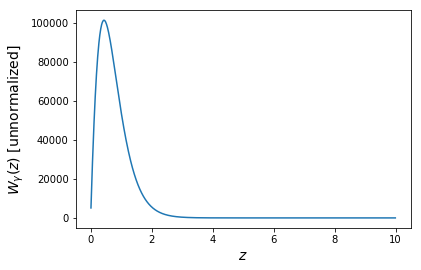

In [67]:
plt.plot(z1_arr,W_z(z1_arr))
plt.ylabel(r'$W_{\gamma}(z)$ [unnormalized]',fontsize=14)
plt.xlabel(r'$z$',fontsize=14)

#### Compute $C_{\ell}^{\gamma\gamma}$

In [89]:
hm = HaloModel(cosm,mf,hp,np.asarray([0.5,0.5]),0.1)

In [ ]:
hm.halo_model()

In [90]:
## Linear theory
P_lin_kz = lambda k,z: cosm.compute_linear_power(k,z)

def P_shm_kz(k,z):
    hm = HaloModel(cosm,mf,hp,k,z)
    return hm.halo_model(-1,-1,'Linear',0,0,0)

def P_shm_IR_res_kz(k,z):
    hm = HaloModel(cosm,mf,hp,k,z)
    return hm.halo_model(-1,-1,'Linear',0,0,1)

In [93]:
ls = np.arange(1,1000,3)
zs = np.arange(0.1,1.,0.1)

def compute_Cls(P_kz):
    pp_int = np.zeros((len(ls),len(zs)))
    for zi,z in enumerate(zs):
        #print(zi)
        ks = (ls+0.5)/chi_z(z)
        pp_int[:,zi] = P_kz(ks,z)
    tmp_integ = lambda z: c/H_z(z)*W_z(z)**2./chi_z(z)**2.
    Cls = simps(tmp_integ(zs)*pp_int,zs)
    return Cls

In [94]:
Cls_lin = compute_Cls(P_lin_kz)
Cls_shm = compute_Cls(P_shm_kz)
Cls_shm_IR_res = compute_Cls(P_shm_IR_res_kz)

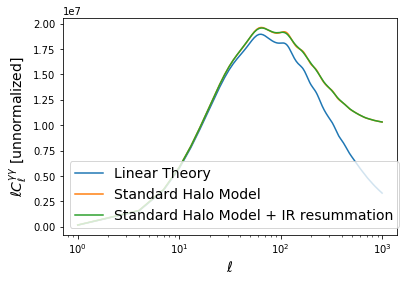

In [95]:
plt.semilogx(ls,ls*Cls_lin,label='Linear Theory')
plt.semilogx(ls,ls*Cls_shm,label='Standard Halo Model')
plt.semilogx(ls,ls*Cls_shm_IR_res,label='Standard Halo Model + IR resummation')
plt.ylabel(r'$\ell C_{\ell}^{\gamma\gamma}$ [unnormalized]',fontsize=14)
plt.xlabel(r'$\ell$',fontsize=14);
plt.legend(fontsize=14);